In [1]:
import pandas as pd
import numpy as np
import torch

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/DengyiLiu/Deep-Learning-05/main/train.csv')
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [5]:
def add_feature(df):
  df['LogFare'] = np.log1p(df['Fare'])
  df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
  df['Family'] = df.SibSp + df.Parch
  df['Alone'] = df.Family==0
  df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
  df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
  df['Title'] = df.Title.map(dict(Mr='Mr', Miss = 'Miss', Mrs = 'Mrs', Master = 'Master'))

In [6]:
add_feature(train)

In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,False,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,False,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,True,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,False,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,True,1,Mr


In [8]:
# use RandomSplitter to separate out the training and validation sets:
splits = RandomSplitter(seed=42)(train)

In [11]:
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

### Now the entire process of getting the data ready for training requires just one cell.

In [17]:
from torch.utils.data import dataloader
dls = TabularPandas(
    train, splits=splits, 
    procs=[Categorify, FillMissing, Normalize],
    cat_names= ['Sex','Pclass','Embarked','Deck','Title'],
    cont_names = ['Age','SibSp','Parch','LogFare','Alone', 'TicketFreq', 'Family'],
    y_names='Survived', y_block = CategoryBlock(),
).dataloaders(path=".")

### Here is what each of parameters means:
* Use splits for indices of training and validation sets:   
splits = splits,
* Turn strings into categories, fill missing values in numeric columns with the median, normalise all numeric columns:   
procs=[Categorify, FillMissing, Normalize],
* These are the categorical independent variables:   
cat_names= ['Sex','Pclass','Embarked','Deck','Title'],
* These are the continuous independent variables:   
cont_names = ['Age','SibSp','Parch','LogFare','Alone', 'TicketFreq', 'Family'],
* This is the dependent variable:   
y_names = 'Survived',
* The dependent variable is categorical (so build a classification model, not a regression model):    
y_block = CategoryBlock(),

# Train the model

In [20]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

### Find the suggestion learning rate of our model.

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

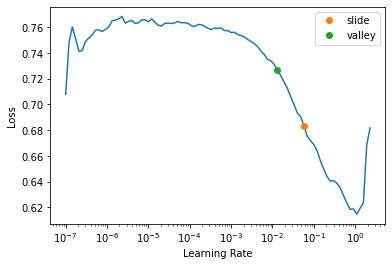

In [21]:
learn.lr_find(suggest_funcs=(slide, valley))

### The two colored points are both reasonable choices for a learning rate. We can pick somewhere between the two(for example 0.03) and train for a few epochs:

In [27]:
learn.fit(16, lr = 0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.281849,0.530716,0.814607,00:00
1,0.282583,0.560667,0.808989,00:00
2,0.292414,0.507815,0.831461,00:00
3,0.297855,0.476668,0.820225,00:00
4,0.294363,0.506574,0.814607,00:00
5,0.299799,0.516465,0.814607,00:00
6,0.295675,0.498364,0.814607,00:00
7,0.295265,0.512871,0.825843,00:00
8,0.293914,0.547261,0.825843,00:00
9,0.294678,0.572321,0.825843,00:00


We need do the same feature engineering we did for the training set.

In [30]:
df_test = pd.read_csv('https://raw.githubusercontent.com/DengyiLiu/Deep-Learning-05/main/test.csv')
tst_df = df_test[['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']].copy()
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_feature(tst_df)

We don't need to manually specify and of the processing steps necessary to get the data ready for modeling, since that's all saved in the learner. To specidy we want to apply the same steps to a new dataset, use the test_dl() method:

In [31]:
tst_dl = learn.dls.test_dl(tst_df)

# Ensembling
Since it's so easy to create a model now, it's easier to play with more adbanced modeling approaches. For instance, we can create five separate models, each trained from different random starting points, and average them. This is the simplest approach of ensembling models, which combines multiple models to generate predictions taht are better than any of the single models in the ensemble.    
To create ensemble, first copy the three steps we used above to create and train a model, and apply it to the test set:

In [28]:
def ensemble():
  learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
  with learn.no_bar(), learn.no_logging(): learn.fit(16, lr = 0.03)
  return learn.get_preds(dl=tst_dl)[0]

# Now run this five times, and collect the results into a list:

In [32]:
learns = [ensemble() for _ in range(5)]

We stack this predictions together and take their average predictions:

In [33]:
ens_preds = torch.stack(learns).mean(0)

Generate a submit file.

In [35]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

In [37]:
! head ens_sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
